# 睡眠時の脳波を誘導できるか検証してみる

In [1]:
import math
import plotly
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## 使用したセンサーとアプリケーション
* [Muse S](https://choosemuse.com/muse-s/)
* [Mind Monitor](https://mind-monitor.com/)

睡眠時は長時間バッテリーが動作する必要があり、寝返り等で電極がずれないようMuseS(Gen1)を使用しました。  
計測データは正規化された脳波の値を使用します  
以下データのサンプルです

In [18]:
header = ["ts", "abs_delta", "abs_theta", "abs_alpha", "abs_beta", "abs_gamma", "rel_delta", "rel_theta", "rel_alpha", "rel_beta", "rel_gamma", "hsi"]
df = pd.read_csv("/logs/sample/waves.csv", names=header)
df["ts"] = df["ts"] - df.iloc[0]["ts"]
df = df.set_index("ts")
df = df.loc[:,["rel_delta", "rel_theta", "rel_alpha", "rel_beta", "rel_gamma"]]
print(df)

header = ["ts", "X", "Y", "Z"]
df_xyz = pd.read_csv("/logs/sample/gyro.csv", names=header)
df_xyz["ts"] = df_xyz["ts"] - df_xyz.iloc[0]["ts"]
df_xyz = df_xyz.set_index("ts")
print(df_xyz)

             rel_delta  rel_theta  rel_alpha  rel_beta  rel_gamma
ts                                                               
0.000000      0.226307    0.14742   0.212869  0.289432   0.097327
0.004579      0.226307    0.14742   0.212869  0.289432   0.097327
0.002861      0.226307    0.14742   0.212869  0.289432   0.097327
0.008472      0.226307    0.14742   0.212869  0.289432   0.097327
0.009727      0.226307    0.14742   0.212869  0.289432   0.097327
...                ...        ...        ...       ...        ...
2383.505793   0.299243    0.15809   0.245185  0.210305   0.075791
2383.502824   0.299243    0.15809   0.245185  0.210305   0.075791
2383.511717   0.299243    0.15809   0.245185  0.210305   0.075791
2383.508861   0.299243    0.15809   0.245185  0.210305   0.075791
2383.513762   0.299243    0.15809   0.245185  0.210305   0.075791

[73931 rows x 5 columns]
                     X         Y         Z
ts                                        
0.000000      6.198273  1.0392

## グラフのプロット

In [13]:
figsize = (20, 3)
rate = 20 # 秒間に受け取るデータ量
# 睡眠状態をプロット
def plot_sleep_stage(waves_file_name, gyro_file_name):
    pd.options.plotting.backend = "matplotlib"
    stage = "wakeup"
    fillcolor_map = {"wakeup": "yellow", "nonrem": "blue", "rem": "green"}
    x0 = 0
    x1 = 0
    header = ["ts", "abs_delta", "abs_theta", "abs_alpha", "abs_beta", "abs_gamma", "rel_delta", "rel_theta", "rel_alpha", "rel_beta", "rel_gamma", "hsi"]
    df = pd.read_csv(waves_file_name, names=header)
    df["ts"] = df["ts"] - df.iloc[0]["ts"]
    df = df.set_index("ts")
    # 正規化された脳波のみを扱います
    df = df.loc[:,["rel_delta", "rel_theta", "rel_alpha", "rel_beta", "rel_gamma"]]
    # 正規化されたデルタ波とアルファ波の差分をとります
    df["offset"] = df["rel_delta"] - df["rel_alpha"]
    # 10分間の移動平均値をとります
    df["offset"] = df["offset"].rolling(600*rate).mean()
    # nullデータは除外します
    df = df.dropna()
    df_offset = df.loc[:,["offset"]]
    
    # グラフの作成
    fig = df_offset.plot(title='sleep stage', figsize=figsize)
    fig.axhline(y=0.25, linestyle=':', color='black')
    fig.axhline(y=0,linestyle=':', color='black')
    fig.axhline(y=-0.2,linestyle=':', color='black')

    # ジャイロセンサーデータの読み込み
    header = ["ts", "X", "Y", "Z"]
    df_xyz = pd.read_csv(gyro_file_name, names=header)
    df_xyz["ts"] = df_xyz["ts"] - df_xyz.iloc[0]["ts"]
    df_xyz = df_xyz.set_index("ts")
    # 10分間移動平均の最大値を求めます
    df_xyz = df_xyz.rolling(600*rate).max()
    # X Y Zの平均値を求める
    df_xyz["avg"] = df_xyz.mean(axis=1)
    df_xyz = df_xyz.dropna()
    df_xyz = df_xyz.loc[:,["avg"]]

    for index,item in df_xyz.iterrows():
        # 10分間体の動きが無ければ入眠とする
        if item["avg"] < 20:
            if x0 != index:
                x1 = index
                fillcolor = fillcolor_map[stage]
                fig.axvspan(x0, x1, alpha=0.2, color=fillcolor)
            x0 = index
            stage = "rem"
            break

    for index,item in df_offset.iterrows():
        # ノンレム睡眠
        if item["offset"] > 0.23 and stage != "nonrem":
            if x0 != index:
                x1 = index
                fillcolor = fillcolor_map[stage]
                fig.axvspan(x0, x1, alpha=0.2, color=fillcolor)
            x0 = index
            stage = "nonrem"
        # レム睡眠
        if item["offset"] < 0 and stage == "nonrem":
            if x0 != index:
                x1 = index
                fillcolor = fillcolor_map[stage]
                fig.axvspan(x0, x1, alpha=0.2, color=fillcolor)
            x0 = index
            stage = "rem"
    
    stage = "rem"
    fillcolor = fillcolor_map[stage]
    fig.axvspan(x0, index, alpha=0.2, color=fillcolor)

## 睡眠ステージの分類方法
* アルファー波とデルタ波の差分の10分移動平均(基本指標)を閾値として睡眠ステージを分類してみる
* ノンレム睡眠からレム睡眠に切り替わるタイミングに寝返りを打つことが多いことから、ジャイロセンサーの閾値と基本指標からステージ変更を検知する
* 入眠のタイミングはジャイロセンサーの10分移動平均を閾値と基本指標から判定する
* 覚醒時も同様に基本指標とジャイロセンサーの閾値から判定する

上記の条件で通常時の睡眠とバイノーラルビート使用時の睡眠を比較してみます

### 通常時の睡眠

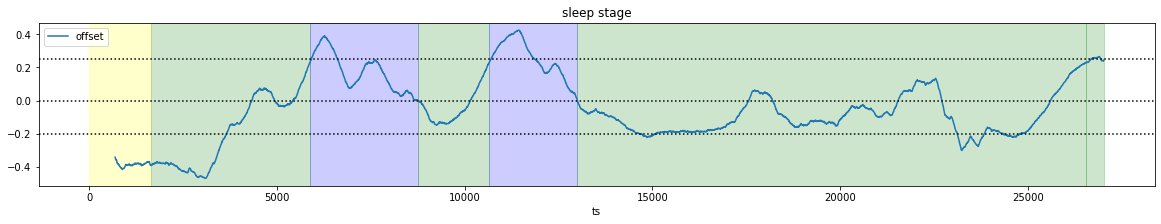

In [14]:
csvdir = "/logs/sleep-2022-05-19"
plot_sleep_stage(f"{csvdir}/waves.csv", f"{csvdir}/gyro.csv")

### バイノーラルビート使用時の睡眠

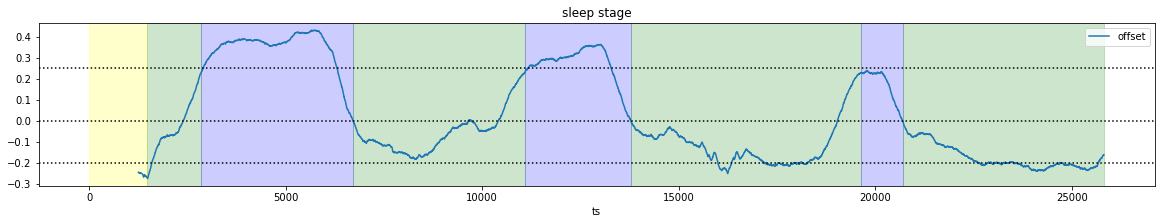

In [4]:
csvdir = "/logs/sleep-2022-05-16"
plot_sleep_stage(f"{csvdir}/waves.csv", f"{csvdir}/gyro.csv")

## まとめ

バイノーラルビート使用時は深い睡眠へ短期間で誘導され、深い睡眠状態の持続時間も比較的長い傾向があった